# Adam Optimizer
## Load Dataset from sklearn

In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()

In [5]:
df = pd.DataFrame(california.data, columns = california.feature_names)
df['Target'] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


In [7]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [9]:
scaler = StandardScaler()
df.values[:,:-1] = scaler.fit_transform(df.values[:,:-1])

df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,-1.216128,-0.289187,-0.155023,0.077354,-0.512592,-0.049110,1.801647,-0.758826,0.781
20636,-0.691593,-0.845393,0.276881,0.462365,-0.944405,0.005021,1.806329,-0.818722,0.771
20637,-1.142593,-0.924851,-0.090318,0.049414,-0.369537,-0.071735,1.778237,-0.823713,0.923
20638,-1.054583,-0.845393,-0.040211,0.158778,-0.604429,-0.091225,1.778237,-0.873626,0.847
20639,-0.780129,-1.004309,-0.070443,0.138403,-0.033977,-0.043682,1.750146,-0.833696,0.894


## Train model with PyTorch

In [10]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

In [11]:
data = torch.from_numpy(df.values).float()
data.shape

torch.Size([20640, 9])

In [12]:
x = data[:, :-1]
y = data[:,-1:]

print(x.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


In [13]:
n_epochs = 4000 
batch_size = 256
print_interval = 100 
#learning_rate = 1e-2

### Build model 

In [35]:
model = nn.Sequential(
    nn.Linear(x.size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)),
)

model
    

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [36]:
# We don't need learning rate hyper-parameter
optimizer = optim.Adam(model.parameters())

In [37]:
# |x| = (total_size, input_dim)
# |y| = (total_size, output_dim)

for i in range(n_epochs) : 
    # Shuffle the index to feed-forward
    indices = torch.randperm(x.size(0))
    x_ = torch.index_select(x, dim = 0, index = indices)
    y_ = torch.index_select(y, dim = 0, index = indices)
    
    x_ = x_.split(batch_size, dim = 0)
    y_ = y_.split(batch_size, dim = 0)
    
    y_hat = [] 
    total_loss = 0
    
    for x_i, y_i in zip(x_, y_) : 
        # |x_i| = |x_[i]|
        # |y_i| = |y_[i]|
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        optimizer.zero_grad() # initialize
        loss.backward() # backpropagation
        
        optimizer.step()
        
        total_loss += float(loss) # very important to prevent memory leak
        y_hat += [y_hat_i]
        
    total_loss = total_loss/len(x_)
    
    if( i + 1 ) % print_interval == 0 : 
        print('Epoch %d : loss = %.4e' % ( i + 1, total_loss))
        

Epoch 100 : loss = 1.3300e+00
Epoch 200 : loss = 1.3293e+00
Epoch 300 : loss = 1.3292e+00
Epoch 400 : loss = 1.3278e+00
Epoch 500 : loss = 1.3288e+00
Epoch 600 : loss = 1.3276e+00
Epoch 700 : loss = 1.3279e+00
Epoch 800 : loss = 1.3266e+00
Epoch 900 : loss = 1.3274e+00
Epoch 1000 : loss = 1.3282e+00
Epoch 1100 : loss = 1.3259e+00
Epoch 1200 : loss = 1.3253e+00
Epoch 1300 : loss = 1.3266e+00
Epoch 1400 : loss = 1.3269e+00
Epoch 1500 : loss = 1.3274e+00
Epoch 1600 : loss = 1.3281e+00
Epoch 1700 : loss = 1.3274e+00
Epoch 1800 : loss = 1.3247e+00
Epoch 1900 : loss = 1.3254e+00
Epoch 2000 : loss = 1.3259e+00
Epoch 2100 : loss = 1.3261e+00
Epoch 2200 : loss = 1.3247e+00
Epoch 2300 : loss = 1.3246e+00
Epoch 2400 : loss = 1.3252e+00
Epoch 2500 : loss = 1.3233e+00
Epoch 2600 : loss = 1.3256e+00
Epoch 2700 : loss = 1.3245e+00
Epoch 2800 : loss = 1.3235e+00
Epoch 2900 : loss = 1.3234e+00
Epoch 3000 : loss = 1.3239e+00
Epoch 3100 : loss = 1.3233e+00
Epoch 3200 : loss = 1.3243e+00
Epoch 3300 : loss

In [38]:
y_hat = torch.cat(y_hat, dim = 0)
y = torch.cat(y_, dim = 0)

### Result 

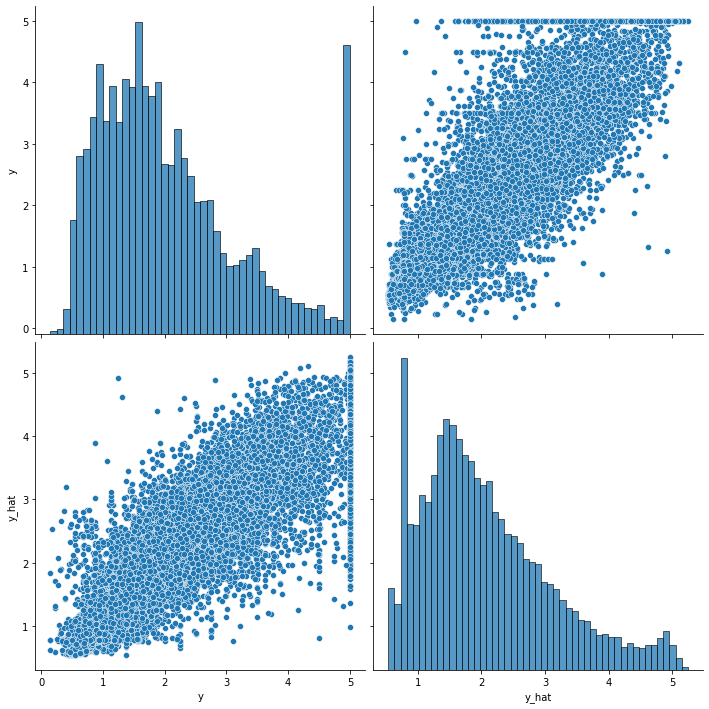

In [34]:
df = pd.DataFrame(torch.cat([y, y_hat], dim = 1).detach().numpy(),
                 columns = ['y', 'y_hat'])

sns.pairplot(df, height = 5)
plt.show()